In [1]:
import numpy as np
import pandas as pd
from utils import read_q_mat, read_a_mat
import scipy.io
import keras
from sim import model_setup, sim_hb, std_operating_policy, max_release, min_release, level_to_storage
import matplotlib.pyplot as plt
import seaborn as sns
from metrics import OF_flood, OF_hydro

import warnings
warnings.filterwarnings("ignore")


## Setting up the model and running it

In [2]:
start_date = '1979-10-01'
end_date = '2006-12-31'
q_vu = '/Users/cooper/Desktop/optimal-wat-allocation/Script/MAT_data/q_vuquang.mat'
q_ye = '/Users/cooper/Desktop/optimal-wat-allocation/Script/MAT_data/q_yenbai.mat'
a = '/Users/cooper/Desktop/optimal-wat-allocation/Script/MAT_data/a_hoabinh_K.mat'

qq, sys_params = model_setup(
    ini_date=start_date,
    fin_date=end_date,
    path_a_hoabinh_K=a,
    path_q_vuquang=q_vu,
    path_q_yenbai=q_ye,
)

In [9]:
qq

{'q_Da':             Streamflow_[m3/s]
 Time                         
 1979-10-01             1900.0
 1979-10-02             1890.0
 1979-10-03             1940.0
 1979-10-04             2440.0
 1979-10-05             2380.0
 ...                       ...
 2006-12-27              489.0
 2006-12-28              457.0
 2006-12-29              445.0
 2006-12-30              450.0
 2006-12-31              467.0
 
 [9954 rows x 1 columns],
 'q_YB':             streamflow_[m3/s]
 time                         
 1979-10-01              858.0
 1979-10-02              821.0
 1979-10-03              800.0
 1979-10-04              884.0
 1979-10-05              906.0
 ...                       ...
 2006-12-27              220.0
 2006-12-28              218.0
 2006-12-29              215.0
 2006-12-30              214.0
 2006-12-31              210.0
 
 [9954 rows x 1 columns],
 'q_VQ':             streamflow_[m3/s]
 time                         
 1979-10-01             1310.0
 1979-10-02          

In [3]:
policy = (89, 107, 1.57, 1.5704, 5000)

res_lvl, release_decision, releaase, h_HaNoi = sim_hb(
    qq=qq,
    h_in=104,
    policy=policy,
    sys_param=sys_params
)

simul = pd.DataFrame({
    'res_lvl': res_lvl,
    'release_decision': release_decision,
    'releaase': releaase,
    'h_HaNoi': h_HaNoi
})

simul['date'] = pd.date_range(start=start_date, end='2007-01-01', freq='D')

312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


In [4]:
simul = simul.set_index('date')
simul = simul.dropna()['1980':'2006']
simul

,res_lvl,release_decision,releaase,h_HaNoi
date,,,,
1980-01-01,86.486948,0.0,5000.0,485.313049
1980-01-02,86.750882,0.0,0.0,482.381958
1980-01-03,87.011266,0.0,0.0,482.339752
1980-01-04,87.266915,0.0,0.0,482.293152
1980-01-05,87.519014,0.0,0.0,482.282593
...,...,...,...,...
2006-12-27,87.757683,0.0,0.0,481.965759
2006-12-28,88.047064,0.0,0.0,481.942291
2006-12-29,88.317508,0.0,0.0,481.928558


## Plotting the current control policy 

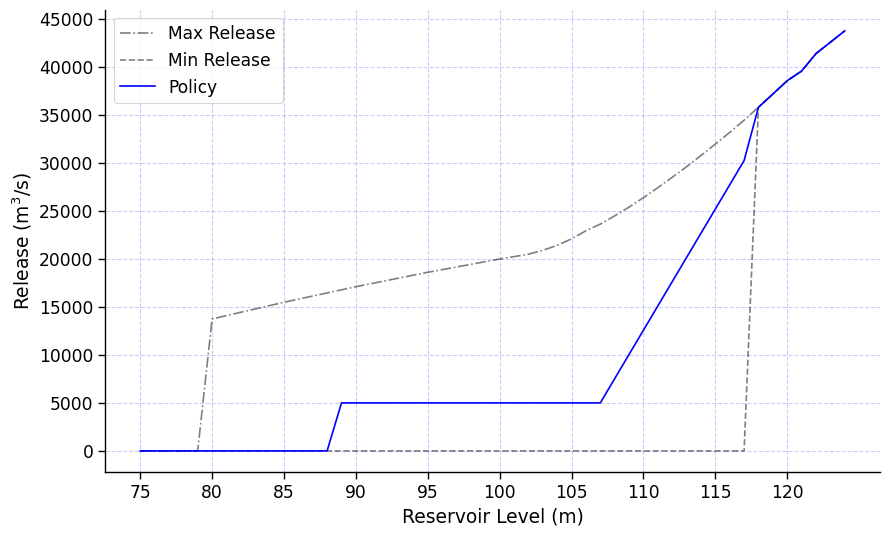

In [5]:
h_levels = [i for i in range(75, 125, 1)]
s_levels = [level_to_storage(h, sys_params) for h in h_levels]
std_releases = [std_operating_policy(h, policy, debug=False) for h in h_levels]
max_releases = [max_release(s, sys_params) for s in s_levels]
min_releases = [min_release(s, sys_params) for s in s_levels]

df = pd.DataFrame({
    'h': h_levels,
    's': s_levels,
    'std_release': std_releases,
    'max_release': max_releases,
    'min_release': min_releases
})

df['actual_release'] = np.where(((df['std_release'] < df['max_release']) & (df['std_release'] >= df['min_release'])), df['std_release'], df['max_release'])


sns.set_context('paper', font_scale=1.4)
fig = plt.figure(figsize=(10, 6))


plt.plot(df['h'], df['max_release'], label='Max Release', linestyle='-.', alpha=0.5, color='black')
plt.plot(df['h'], df['min_release'], label='Min Release', linestyle='--', alpha=0.5, color='black')
plt.plot(df['h'], df['actual_release'], label='Policy', color='#0000FF')
plt.xlabel('Reservoir Level (m)')
plt.ylabel('Release (m$^3$/s)')
sns.despine()
plt.grid(alpha=0.2, linestyle='--', color='#0000FF')
plt.xticks(np.arange(75, 125, 5))
plt.yticks(np.arange(0, 50000, 5000))
plt.legend()
# plt.savefig('/Users/cooper/Desktop/optimal-wat-allocation/images/current_policy.png', dpi=300, bbox_inches='tight')
plt.show()





## Plotting the time series of simulated reservoir level, release, and water level in Hanoi for the period 1995-2006.

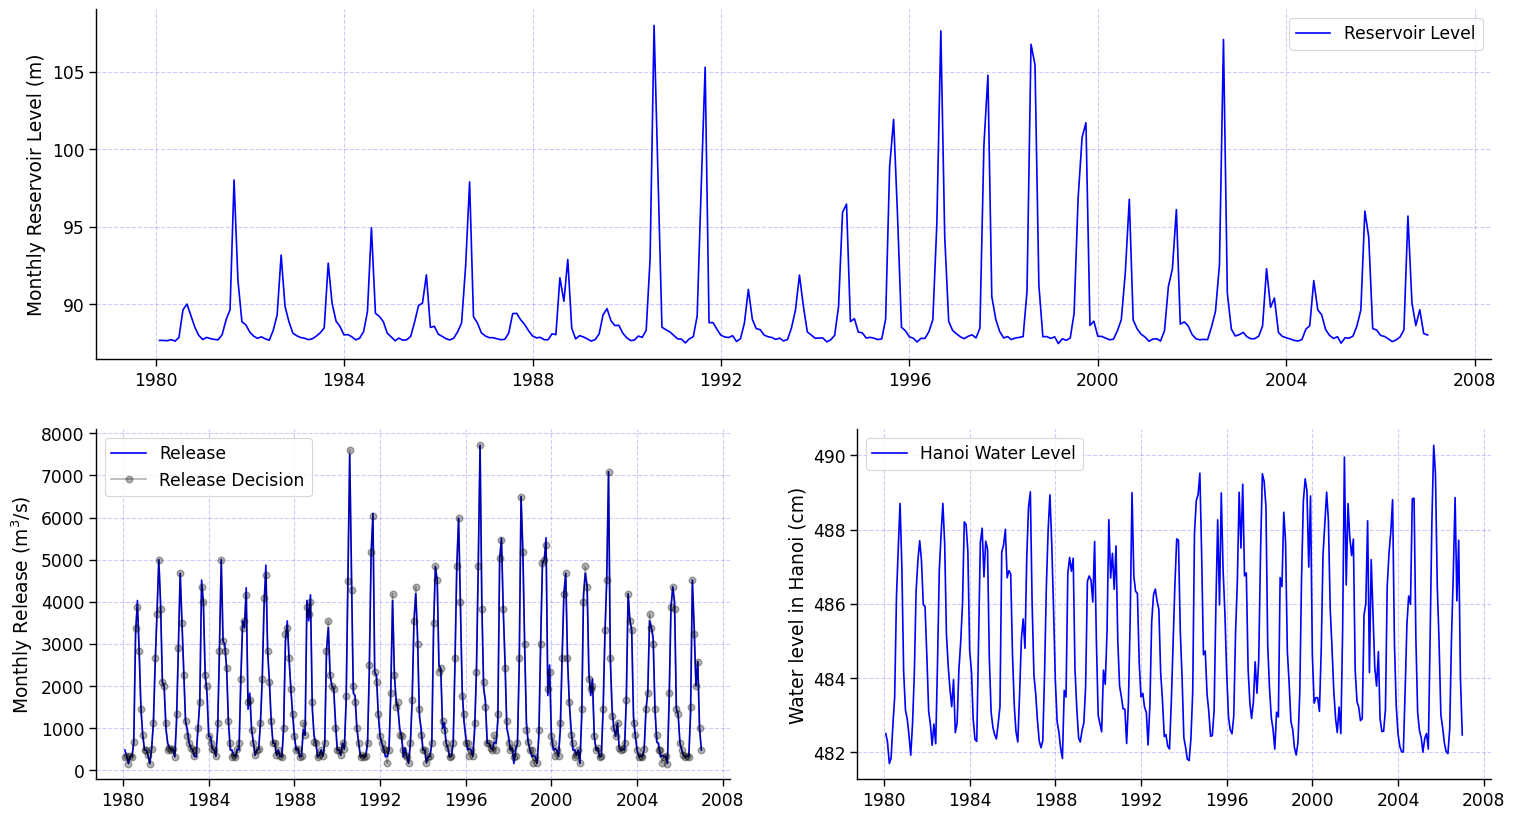

In [6]:
simul_monthly = simul.resample('ME').mean()

sns.set_context('paper', font_scale=1.4)
fig = plt.figure(figsize=(18, 10))

layout = (2, 2)

ax_res_lvl = plt.subplot2grid(layout, (0, 0), colspan=2)
# ax_release_decision = plt.subplot2grid(layout, (0, 1), colspan=1)
ax_release = plt.subplot2grid(layout, (1, 0), colspan=1)
ax_h = plt.subplot2grid(layout, (1, 1), colspan=1)


ax_res_lvl.plot(simul_monthly.index, simul_monthly['res_lvl'], label='Reservoir Level', color='#0000FF')
ax_res_lvl.set_xlabel('')
ax_res_lvl.set_ylabel('Monthly Reservoir Level (m)')
ax_res_lvl.grid(alpha=0.2, linestyle='--', color='#0000FF')
ax_res_lvl.legend()

# ax_release_decision.plot(simul_monthly.index, simul_monthly['release_decision'], label='Release Decision', color='#0000FF')
# ax_release_decision.set_xlabel('Date')
# ax_release_decision.set_ylabel('Monthly Release Decision (m$^3$/s)')
# ax_release_decision.grid(alpha=0.2, linestyle='--', color='#0000FF')

ax_release.plot(simul_monthly.index, simul_monthly['releaase'], label='Release', color='#0000FF')
ax_release.plot(simul_monthly.index, simul_monthly['release_decision'], label='Release Decision', color='black', marker='o', alpha=0.3)
ax_release.set_xlabel('')
ax_release.set_ylabel('Monthly Release (m$^3$/s)')
ax_release.grid(alpha=0.2, linestyle='--', color='#0000FF')
ax_release.legend()

ax_h.plot(simul_monthly.index, simul_monthly['h_HaNoi'], label='Hanoi Water Level', color='#0000FF')
ax_h.set_xlabel('')
ax_h.set_ylabel('Water level in Hanoi (cm)')
ax_h.grid(alpha=0.2, linestyle='--', color='#0000FF')
ax_h.legend()

sns.despine()
# plt.savefig('/Users/cooper/Desktop/optimal-wat-allocation/images/current_simulation.png', dpi=300, bbox_inches='tight')
plt.show()

## Computing the current performance in the two operating objectives

In [7]:
inflow_resrvoir = read_a_mat(a)
inflow_resrvoir = inflow_resrvoir['1980':'2006']
inflow_resrvoir

,Streamflow_[m3/s]
Time,
1980-01-01,446.0
1980-01-02,440.0
1980-01-03,432.0
1980-01-04,426.0
1980-01-05,418.0
...,...
2006-12-27,489.0
2006-12-28,457.0
2006-12-29,445.0


In [8]:
J_Flood = OF_flood(ht_HN=simul["h_HaNoi"])
J_HP = OF_hydro(qt=inflow_resrvoir, rt=simul["releaase"], ht=simul["res_lvl"])

print(f'Curent performance for flood: {J_Flood}. Current performance for hydro: {J_HP}')

Curent performance for flood: 0.0. Current performance for hydro: 10.46
